In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])

from sgtlstm.utils import create_dataset, recover_timedelta_to_timestamp
from sgtlstm.SeqGan import build_G, build_D, build_critic
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3
# from sgtlstm.train import generate_batch_sequence_by_rollout, train_discriminator, train_generator

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')


## Load data 

In [4]:
pos_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v10/positive_long_sequences.pickle'

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, timestamp)
        [[(1, 11), (1, 24), (2, 37), (3, 47), (2, 63), (2, 80), (1, 88), (2, 95), (2, 104), (3, 111)], ...]
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, timestamp_seqs)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)

## Global Variables 

In [5]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 6
HIDDEN_DIM = 100

END_TOKEN = 0
MAX_TIME = 1024

## Load pretrained model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_D_2(T, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a discriminator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param T: length of the sequence
    :param event_vocab_dim: size of event vocabulary ['na', 'init', 'start', 'view', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return: discriminator D
    """
    # Time-LSTM:
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T, 1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)
    masked_et = mask_layer(i_et)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, input_length=T, mask_zero=True)(masked_et)
    embed0 = Reshape((T, emb_dim))(embed0)  # shape=[Batch_size, T, emb_dim]
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)  # # shape=[Batch_size, T, emb_dim + time_dim]

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', return_sequences=False)(merged0)

    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)

    # predicted real prob
    real_prob = Dense(1, activation='sigmoid', name='fraud_prob', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3))(
        time_comb)

    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=[real_prob])

    return discriminator

def build_G_2(batch_size, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a generator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param batch_size: batch size must been specified at generator
    :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return:
    """
    # Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta')  # input of continuous feature timestamp

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    masked_ts = mask_layer(i_ts)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = Reshape([1, emb_dim])(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm',
                       stateful=True, return_sequences=False)(merged0)
    
    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_time = Dense(hidden_dim // 2, activation='linear', name='dense_time')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_time)
    time_out = Dense(1 + 1, activation='linear', name='output')(dense_token)
    time_out = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1 + tf.math.softplus(t[..., 1:])),
        name='Normal')(time_out)

    # predicted prob of next token
    dense_token = Dense(hidden_dim // 2, activation='linear', name='dense_token')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_token)
    token_prob = Dense(event_vocab_dim, activation='softmax', name='token_prob')(dense_token)
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_prob, time_out])
    return generator


In [7]:
discriminator = build_D_2(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

discriminator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

D_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_disc_weights/model.tf'
discriminator.load_weights(D_save_path)

In [8]:
generator = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

generator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_gen_weights/model_dropout.tf'
generator.load_weights(G_save_path)

## Create a critic network

In [9]:
critic = build_critic(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

using sigmoid!


# functions in training

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

In [11]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1.0, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_ts = tf.zeros([batch_size, 1, 1], dtype=tf.float64)

    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    episode_token_probs = tf.constant(1., dtype=tf.float64, shape=(batch_size, 1))
    gaussian_log = tf.constant(0., dtype=tf.float64, shape=(batch_size, 1))

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, time_out = G([curr_state_et, curr_state_ts])

        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # get the chosen token probability per batch for each step
        batch_sample_et = tf.reshape(sampled_et, (batch_size, 1))
        batch_ind = tf.reshape(tf.range(0, batch_size), (batch_size, 1))
        batch_sample_et_2d = tf.concat([batch_ind, batch_sample_et], axis=1)

        sampled_token_prob = tf.reshape(tf.gather_nd(token_prob, batch_sample_et_2d), (batch_size, 1))
        episode_token_probs = tf.concat([episode_token_probs, sampled_token_prob], axis=1)

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using time_out
        sampled_ts_raw = time_out.sample()
        sampled_ts = tf.clip_by_value(tf.reshape(sampled_ts_raw, (batch_size, 1, 1))
                                      , clip_value_min=0, clip_value_max=max_time)

        # get the gaussian log likelihood for the sampled timestamps
        sampled_gaussian_log = time_out.log_prob(sampled_ts_raw)
        gaussian_log = tf.concat([gaussian_log, sampled_gaussian_log], axis=1)

        # stop generating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_et, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)

    return all_state_et, all_state_ts, episode_token_probs, gaussian_log


In [12]:
def generate_sequences(N_gen, generator, batch_size, T, recover_to_timestamp=True):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :param recover_to_timestamp: whether to recover time deltas to absolute timestamps
    :return: a python list of shape [N_gen, T, 2]
    """
    all_type_seq = None
    all_time_seq = None
    N = 0

    while N < N_gen:
        batch_state_et, batch_state_ts, _, _ = generate_batch_sequence_by_rollout(generator, batch_size, T,
                                                                                  end_token=0, init_token=1.0,
                                                                                  max_time=1024, verbose=False)

        batch_type_seq = batch_state_et.numpy()
        batch_time_seq = batch_state_ts.numpy()

        # recover time delta to time stamps
        if recover_to_timestamp:
            batch_time_seq = np.cumsum(batch_time_seq, axis=1)

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        if all_time_seq is None:
            all_time_seq = batch_time_seq
        else:
            all_time_seq = np.concatenate([all_time_seq, batch_time_seq], axis=0)

        N += batch_size

    # concat type and time in depth
    concated_seq_list = np.concatenate([all_type_seq, all_time_seq], axis=2).tolist()

    return concated_seq_list[:N_gen]


In [13]:
def train_generator(generator, discriminator, critic_network, batch_size, T, verbose=False,
                    weight_gaussian_loss=1,
                    optimizer=Adam(lr=0.001)):
    # reset hidden states for critic network per batch
    critic_network.reset_states()

    with tf.GradientTape(persistent=True) as tape:
        states_et, states_ts, episode_token_probs, gaussian_log = generate_batch_sequence_by_rollout(generator,
                                                                                                     batch_size, T,
                                                                                                     end_token=0,
                                                                                                     init_token=1.0,
                                                                                                     max_time=1024,
                                                                                                     verbose=False)
        ce_loss_list = []
        gaussian_list = []
        critic_loss_list = []

        # run disc on whole sequence
        # true_return is the total reward for generating this seq
        true_return = discriminator((states_et, states_ts))
        
        ZERO_PENALTY = 1

        for i in range(0, T):
            # TODO: should we include the init token in loss?
            curr_state_et = states_et[:, i:i + 1, :]
            curr_state_ts = states_ts[:, i:i + 1, :]

            curr_token_prob = episode_token_probs[:, i:i + 1]
            curr_gaussian_log = gaussian_log[:, i:i + 1]

            q_value = critic_network([curr_state_et, curr_state_ts])
            advantage = true_return - q_value

            # At this point in history, the critic estimated that we would get a
            # total reward = `q_value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `true_return`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.            
            
#             mask = tf.squeeze(curr_state_et)
#             curr_state_et = tf.boolean_mask(curr_state_et, mask)
#             curr_state_ts = tf.boolean_mask(curr_state_ts, mask)
#             curr_token_prob = tf.boolean_mask(curr_token_prob, mask)
#             curr_gaussian_log = tf.boolean_mask(curr_gaussian_log, mask)
            
            if curr_state_et.shape[0] == 0:
                ce_loss_list.append(ZERO_PENALTY)
                continue

#             masked_q_value = tf.boolean_mask(q_value, mask)
#             masked_advantage = tf.boolean_mask(advantage, mask)
#             masked_true_return = tf.boolean_mask(true_return, mask)            
            
            ce_loss_list.append(-tf.reduce_mean(tf.math.log(curr_token_prob) * advantage))
            gaussian_list.append(-tf.reduce_mean(curr_gaussian_log * advantage))

            ce_loss_list.append(-tf.reduce_mean(tf.math.log(curr_token_prob)))
            gaussian_list.append(-tf.reduce_mean(curr_gaussian_log))

            critic_loss_list.append(tf.reduce_mean(tf.keras.losses.MSE(true_return, q_value)))

        total_ce_loss = tf.reduce_mean(ce_loss_list)
        total_gaussian_loss = tf.reduce_mean(gaussian_list)
        total_critic_loss = tf.reduce_mean(critic_loss_list)        
        total_generator_loss = total_ce_loss + weight_gaussian_loss * total_gaussian_loss

        average_true_return = tf.reduce_mean(true_return)

        if verbose:
            print('generator token loss:{}'.format(total_ce_loss))
            print('generator gaussian loss:{}'.format(total_gaussian_loss))
            print('generator total loss:{}'.format(total_generator_loss))
            print('generator critic loss:{}'.format(total_critic_loss))
            print('average true_return: {}'.format(average_true_return))
            print('-----------------------')

    # update generator
    generator_grads = tape.gradient(total_generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    # update critic network
    critic_grads = tape.gradient(total_critic_loss, critic_network.trainable_variables)
    optimizer.apply_gradients(zip(critic_grads, critic_network.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return total_ce_loss, total_gaussian_loss, total_critic_loss, average_true_return

In [14]:
def train_discriminator(features_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        real_et, real_ts = features_batch
        # (batch_size, 1)
        real_labels = tf.ones((batch_size, 1)) + tfd.Normal(loc=0, scale=0.1, name='normal_disturbance_true').sample(sample_shape=(batch_size, 1))                
#         real_labels = tf.clip_by_value(real_labels, clip_value_min=0.0, clip_value_max=1.0)
        

        generated_et, generated_ts, episode_token_probs, gaussian_log = generate_batch_sequence_by_rollout(generator,
                                                                                                           batch_size,
                                                                                                           T,
                                                                                                           end_token=0,
                                                                                                           init_token=1.0,
                                                                                                           max_time=1024,
                                                                                                           verbose=False)

        generated_labels = tf.zeros((batch_size, 1)) + tfd.Normal(loc=0, scale=0.1, name='normal_disturbance_fake').sample(sample_shape=(batch_size, 1))
#         generated_labels = tf.clip_by_value(generated_labels, clip_value_min=0.0, clip_value_max=1.0)

        total_et = tf.concat([generated_et, real_et], axis=0)
        total_ts = tf.concat([generated_ts, real_ts], axis=0)
        total_labels = tf.concat([generated_labels, real_labels], axis=0)

        # train discriminator
        pred_prob = discriminator((total_et, total_ts))

        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))
        discriminator_loss = ce_loss

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return ce_loss

# Train G and D

In [15]:
train_et = pos_event_type_seqs
train_ts = pos_timestamp_seqs

train_labels = np.ones((pos_event_type_seqs.shape[0], 1))

train_features = (train_et, train_ts)
N_train = train_et.shape[0]
N_train

154189

In [16]:
EPOCHS = 1

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         buffer_size=N_train)

gen_token_loss_history = []
gen_gaussian_loss_history = []
critic_network_loss_history = []
average_true_return_history = []

disc_ce_loss_history = []

In [19]:
_TOTAL_STEPS = int(EPOCHS * N_train / BATCH_SIZE)
_TOTAL_STEPS = 50

step = 0

In [23]:
G_optimizer = SGD(learning_rate=1e-3)
D_optimizer = SGD(learning_rate=1e-3)

WEIGHT_GAUSSIAN_LOSS = 1
_G_STEPS = 1
_D_STEPS = 1

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss, critic_network_loss, average_true_return = train_generator(generator, discriminator, critic, 
                                                                                 batch_size=BATCH_SIZE, T=T, verbose=True, 
                                                                                 weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS,
                                                                                 optimizer=G_optimizer
                                                                                )
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())    
        critic_network_loss_history.append(critic_network_loss.numpy())
        average_true_return_history.append(average_true_return.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_ce_loss = train_discriminator(features_batch, generator, discriminator, 
                                           batch_size=BATCH_SIZE, T=T, verbose=True, 
                                           optimizer=D_optimizer)
        disc_ce_loss_history.append(disc_ce_loss.numpy())

0it [00:00, ?it/s]

Training Step: 51
generator token loss:0.6422608902513578
generator gaussian loss:1.7658947550505686
generator total loss:2.4081556453019264
generator critic loss:0.1282582026606533
average true_return: 0.5929394037259383
-----------------------
total discriminator loss:0.994518660627848
-----------------------


1it [00:03,  3.71s/it]

Training Step: 52
generator token loss:0.6286982283507155
generator gaussian loss:1.7577993646390249
generator total loss:2.3864975929897403
generator critic loss:0.10444872362766366
average true_return: 0.5847701847283532
-----------------------
total discriminator loss:0.9262128842091377
-----------------------


2it [00:07,  3.64s/it]

Training Step: 53
generator token loss:0.6229745049881401
generator gaussian loss:1.7118569132164285
generator total loss:2.3348314182045686
generator critic loss:0.11845789804152261
average true_return: 0.5726551533467734
-----------------------
total discriminator loss:0.915855605290372
-----------------------


3it [00:10,  3.58s/it]

Training Step: 54
generator token loss:0.6341964548864777
generator gaussian loss:1.772982131313503
generator total loss:2.4071785861999806
generator critic loss:0.12590977704729647
average true_return: 0.5961685183851744
-----------------------
total discriminator loss:0.8736885511211654
-----------------------


4it [00:14,  3.52s/it]

Training Step: 55
generator token loss:0.611983633670353
generator gaussian loss:1.6913745015952426
generator total loss:2.3033581352655954
generator critic loss:0.12034751202264311
average true_return: 0.5544659918492119
-----------------------
total discriminator loss:0.8662604972192222
-----------------------


5it [00:17,  3.49s/it]

Training Step: 56
generator token loss:0.6448462211554987
generator gaussian loss:1.8046967284009692
generator total loss:2.449542949556468
generator critic loss:0.11010323069956077
average true_return: 0.6142815525750448
-----------------------
total discriminator loss:0.927935061582438
-----------------------


6it [00:20,  3.47s/it]

Training Step: 57
generator token loss:0.6082678777114493
generator gaussian loss:1.6464128325109095
generator total loss:2.2546807102223587
generator critic loss:0.11137805604195077
average true_return: 0.5409438940674339
-----------------------
total discriminator loss:0.995005534593864
-----------------------


7it [00:24,  3.46s/it]

Training Step: 58
generator token loss:0.6248096199616275
generator gaussian loss:1.7296525425115854
generator total loss:2.354462162473213
generator critic loss:0.10221108031142148
average true_return: 0.5826207617897413
-----------------------
total discriminator loss:0.9966172901010633
-----------------------


8it [00:27,  3.47s/it]

Training Step: 59
generator token loss:0.5641617045008789
generator gaussian loss:1.5266536694065733
generator total loss:2.090815373907452
generator critic loss:0.12106518368022148
average true_return: 0.4697307300311836
-----------------------
total discriminator loss:0.8707080831775598
-----------------------


9it [00:31,  3.45s/it]

Training Step: 60
generator token loss:0.6161594439355107
generator gaussian loss:1.6668632747281047
generator total loss:2.2830227186636156
generator critic loss:0.11315164243515043
average true_return: 0.5558563294166847
-----------------------
total discriminator loss:0.6511684983724488
-----------------------


10it [00:34,  3.43s/it]

Training Step: 61
generator token loss:0.6304709251204894
generator gaussian loss:1.6984485147415622
generator total loss:2.3289194398620516
generator critic loss:0.11949526168381802
average true_return: 0.5724711994924725
-----------------------
total discriminator loss:0.9884205207237932
-----------------------


11it [00:37,  3.42s/it]

Training Step: 62
generator token loss:0.6349585756454149
generator gaussian loss:1.7437174798704351
generator total loss:2.37867605551585
generator critic loss:0.09996074081621946
average true_return: 0.5924800619481796
-----------------------
total discriminator loss:0.9652899128009537
-----------------------


12it [00:41,  3.46s/it]

Training Step: 63
generator token loss:0.5724691814805022
generator gaussian loss:1.5576219685452979
generator total loss:2.1300911500258
generator critic loss:0.11501735866882637
average true_return: 0.48925159794366846
-----------------------
total discriminator loss:0.8585409701870735
-----------------------


13it [00:45,  3.50s/it]

Training Step: 64
generator token loss:0.6436055917028959
generator gaussian loss:1.764103171270768
generator total loss:2.4077087629736638
generator critic loss:0.08905744225404601
average true_return: 0.6077592970250033
-----------------------
total discriminator loss:0.7799146754615165
-----------------------


14it [00:48,  3.52s/it]

Training Step: 65
generator token loss:0.6162256378242549
generator gaussian loss:1.6784905601291678
generator total loss:2.2947161979534227
generator critic loss:0.10541641928194176
average true_return: 0.5570888667245617
-----------------------
total discriminator loss:0.7082772363709784
-----------------------


15it [00:52,  3.51s/it]

Training Step: 66
generator token loss:0.5899506652302688
generator gaussian loss:1.593918147503998
generator total loss:2.183868812734267
generator critic loss:0.12315748179453957
average true_return: 0.5140778926315397
-----------------------
total discriminator loss:0.8593205687681906
-----------------------


16it [00:55,  3.49s/it]

Training Step: 67
generator token loss:0.6215951091317533
generator gaussian loss:1.6788640101832115
generator total loss:2.300459119314965
generator critic loss:0.09512230398720374
average true_return: 0.5639016406395834
-----------------------
total discriminator loss:0.8274144137099921
-----------------------


17it [00:59,  3.47s/it]

Training Step: 68
generator token loss:0.6413846117218528
generator gaussian loss:1.7236237602581832
generator total loss:2.365008371980036
generator critic loss:0.09688268374525584
average true_return: 0.6010028104472018
-----------------------
total discriminator loss:0.8348883613580991
-----------------------


18it [01:02,  3.44s/it]

Training Step: 69
generator token loss:0.6368979812746169
generator gaussian loss:1.7204455018119802
generator total loss:2.357343483086597
generator critic loss:0.1036907183741847
average true_return: 0.5885084477929401
-----------------------
total discriminator loss:0.8341883176972009
-----------------------


19it [01:05,  3.42s/it]

Training Step: 70
generator token loss:0.6251411215042152
generator gaussian loss:1.6873412396997396
generator total loss:2.312482361203955
generator critic loss:0.0958972009894273
average true_return: 0.5749057598504632
-----------------------
total discriminator loss:1.0403988536984223
-----------------------


20it [01:09,  3.43s/it]

Training Step: 71
generator token loss:0.6130173285374194
generator gaussian loss:1.6469997069677778
generator total loss:2.2600170355051974
generator critic loss:0.0940134731516898
average true_return: 0.556447570854901
-----------------------
total discriminator loss:1.0180927145475205
-----------------------


21it [01:12,  3.45s/it]

Training Step: 72
generator token loss:0.6094149902563065
generator gaussian loss:1.631082820491315
generator total loss:2.2404978107476214
generator critic loss:0.13075638021412497
average true_return: 0.5460144379561104
-----------------------
total discriminator loss:0.7983495601851018
-----------------------


22it [01:16,  3.43s/it]

Training Step: 73
generator token loss:0.5976266415621893
generator gaussian loss:1.6274680316662153
generator total loss:2.2250946732284045
generator critic loss:0.09477599591323231
average true_return: 0.5303862958416099
-----------------------
total discriminator loss:0.8416055114674994
-----------------------


23it [01:19,  3.42s/it]

Training Step: 74
generator token loss:0.6231600015251003
generator gaussian loss:1.672493744253282
generator total loss:2.2956537457783823
generator critic loss:0.0972004166792962
average true_return: 0.5719266632496622
-----------------------
total discriminator loss:0.8777153340860103
-----------------------


24it [01:23,  3.46s/it]

Training Step: 75
generator token loss:0.5913060071406117
generator gaussian loss:1.575256288874572
generator total loss:2.166562296015184
generator critic loss:0.08627315064150187
average true_return: 0.5168050846023171
-----------------------
total discriminator loss:0.7571437684457376
-----------------------


25it [01:26,  3.45s/it]

Training Step: 76
generator token loss:0.5834755818970357
generator gaussian loss:1.582223580930263
generator total loss:2.165699162827299
generator critic loss:0.11798422298594065
average true_return: 0.5219044226076115
-----------------------
total discriminator loss:0.782192926812424
-----------------------


26it [01:29,  3.44s/it]

Training Step: 77
generator token loss:0.5985072901248024
generator gaussian loss:1.5987588892720572
generator total loss:2.1972661793968595
generator critic loss:0.11291729114755455
average true_return: 0.5293505723155925
-----------------------
total discriminator loss:0.9264713572703099
-----------------------


27it [01:33,  3.45s/it]

Training Step: 78
generator token loss:0.5786833810973306
generator gaussian loss:1.5351200218192576
generator total loss:2.113803402916588
generator critic loss:0.11043398242583467
average true_return: 0.48821481521396637
-----------------------
total discriminator loss:0.721434419113885
-----------------------


28it [01:36,  3.47s/it]

Training Step: 79
generator token loss:0.6312822805815753
generator gaussian loss:1.6869161072628496
generator total loss:2.318198387844425
generator critic loss:0.08734394341105321
average true_return: 0.5872554292468214
-----------------------
total discriminator loss:0.935730093770889
-----------------------


29it [01:40,  3.47s/it]

Training Step: 80
generator token loss:0.5823889810092608
generator gaussian loss:1.586763682902822
generator total loss:2.169152663912083
generator critic loss:0.09765812474929844
average true_return: 0.5130951622990247
-----------------------
total discriminator loss:0.9687872170489088
-----------------------


30it [01:43,  3.48s/it]

Training Step: 81
generator token loss:0.5927904322200732
generator gaussian loss:1.5962389314726029
generator total loss:2.189029363692676
generator critic loss:0.10397256741533958
average true_return: 0.5295868036872691
-----------------------
total discriminator loss:0.8764921562053543
-----------------------


31it [01:47,  3.48s/it]

Training Step: 82
generator token loss:0.6127042438778986
generator gaussian loss:1.6194183187510443
generator total loss:2.232122562628943
generator critic loss:0.1056632809097136
average true_return: 0.5520660988140251
-----------------------
total discriminator loss:0.9120247680709634
-----------------------


32it [01:50,  3.47s/it]

Training Step: 83
generator token loss:0.5620080320796563
generator gaussian loss:1.491824543000333
generator total loss:2.0538325750799893
generator critic loss:0.0895070802848091
average true_return: 0.4756074521573814
-----------------------
total discriminator loss:0.9160407992893265
-----------------------


33it [01:54,  3.48s/it]

Training Step: 84
generator token loss:0.5785135138081878
generator gaussian loss:1.5407258869696885
generator total loss:2.119239400777876
generator critic loss:0.09994174005341054
average true_return: 0.5009620187930363
-----------------------
total discriminator loss:0.8872866536916801
-----------------------


34it [01:57,  3.49s/it]

Training Step: 85
generator token loss:0.6062614036326943
generator gaussian loss:1.5943016294898922
generator total loss:2.2005630331225863
generator critic loss:0.08064074127535024
average true_return: 0.5484829261488775
-----------------------
total discriminator loss:0.7765764137968353
-----------------------


35it [02:01,  3.49s/it]

Training Step: 86
generator token loss:0.5704294938256572
generator gaussian loss:1.504955556004545
generator total loss:2.075385049830202
generator critic loss:0.09996075172453804
average true_return: 0.48274362247636277
-----------------------
total discriminator loss:0.8683498401800898
-----------------------


36it [02:04,  3.50s/it]

Training Step: 87
generator token loss:0.5500903888776985
generator gaussian loss:1.4607078848772455
generator total loss:2.010798273754944
generator critic loss:0.10448764992077718
average true_return: 0.45716189041305166
-----------------------
total discriminator loss:0.7474550316609299
-----------------------


37it [02:08,  3.50s/it]

Training Step: 88
generator token loss:0.6025611288261674
generator gaussian loss:1.5958737046406481
generator total loss:2.1984348334668153
generator critic loss:0.10438380901032804
average true_return: 0.5409795756529925
-----------------------
total discriminator loss:0.7158577900879919
-----------------------


38it [02:11,  3.53s/it]

Training Step: 89
generator token loss:0.6107912520745241
generator gaussian loss:1.6167697106360945
generator total loss:2.2275609627106188
generator critic loss:0.09002857093486054
average true_return: 0.5581100497164422
-----------------------
total discriminator loss:0.6884989898816931
-----------------------


39it [02:15,  3.51s/it]

Training Step: 90
generator token loss:0.5824826830109341
generator gaussian loss:1.490241248149744
generator total loss:2.072723931160678
generator critic loss:0.10587101462246179
average true_return: 0.4964481797564706
-----------------------
total discriminator loss:0.8804418758142296
-----------------------


40it [02:18,  3.49s/it]

Training Step: 91
generator token loss:0.6073967799438396
generator gaussian loss:1.5735420536201066
generator total loss:2.180938833563946
generator critic loss:0.08639449391840398
average true_return: 0.5383291428944756
-----------------------
total discriminator loss:0.7033484178775793
-----------------------


41it [02:22,  3.50s/it]

Training Step: 92
generator token loss:0.5462642446636582
generator gaussian loss:1.3976320157717128
generator total loss:1.9438962604353711
generator critic loss:0.09244187436261773
average true_return: 0.440855886829631
-----------------------
total discriminator loss:0.7831355942419936
-----------------------


42it [02:25,  3.54s/it]

Training Step: 93
generator token loss:0.5845013682340172
generator gaussian loss:1.5318544848065372
generator total loss:2.116355853040554
generator critic loss:0.09566599943160178
average true_return: 0.5134108005181476
-----------------------
total discriminator loss:0.7836926611726807
-----------------------


43it [02:29,  3.53s/it]

Training Step: 94
generator token loss:0.6040230063825084
generator gaussian loss:1.5721942659953163
generator total loss:2.1762172723778246
generator critic loss:0.07030605239026608
average true_return: 0.5460662923525221
-----------------------
total discriminator loss:0.8008853259880817
-----------------------


44it [02:32,  3.51s/it]

Training Step: 95
generator token loss:0.645199060242782
generator gaussian loss:1.6586308610451785
generator total loss:2.3038299212879605
generator critic loss:0.071965062886023
average true_return: 0.6089619076466561
-----------------------
total discriminator loss:0.7957742720581605
-----------------------


45it [02:36,  3.50s/it]

Training Step: 96
generator token loss:0.5776343991733635
generator gaussian loss:1.4975217237128395
generator total loss:2.075156122886203
generator critic loss:0.10102735874680449
average true_return: 0.5026232608013053
-----------------------
total discriminator loss:0.7194026412483133
-----------------------


46it [02:39,  3.50s/it]

Training Step: 97
generator token loss:0.6313320574758153
generator gaussian loss:1.636591102972586
generator total loss:2.2679231604484014
generator critic loss:0.062406101443011966
average true_return: 0.5932957152004681
-----------------------
total discriminator loss:0.8555444320795726
-----------------------


47it [02:43,  3.47s/it]

Training Step: 98
generator token loss:0.5947071884696198
generator gaussian loss:1.5145989376443498
generator total loss:2.1093061261139696
generator critic loss:0.06683135524414008
average true_return: 0.5387495992495439
-----------------------
total discriminator loss:0.7825019318166309
-----------------------


48it [02:46,  3.46s/it]

Training Step: 99
generator token loss:0.5679916827019014
generator gaussian loss:1.4481618624308599
generator total loss:2.0161535451327612
generator critic loss:0.08839862546588059
average true_return: 0.4896053674079359
-----------------------
total discriminator loss:0.680904841734119
-----------------------


49it [02:50,  3.44s/it]

Training Step: 100
generator token loss:0.5758021295878994
generator gaussian loss:1.4650423618093298
generator total loss:2.0408444913972295
generator critic loss:0.08500924591536115
average true_return: 0.5028790984049275
-----------------------
total discriminator loss:0.8422310850780019
-----------------------


50it [02:53,  3.47s/it]


## 1000 steps: Loss over training

Text(0.5, 0, 'training steps')

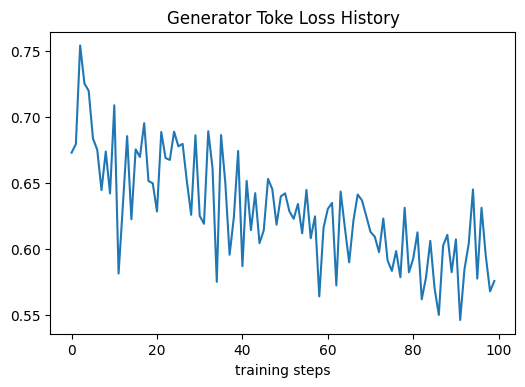

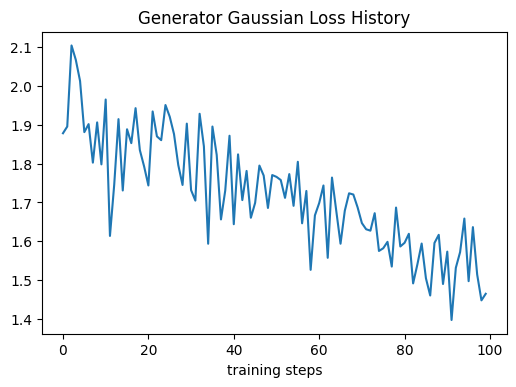

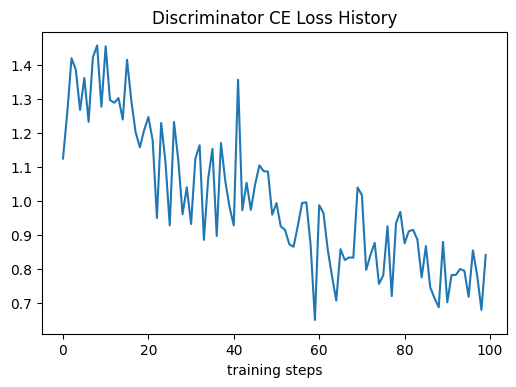

In [24]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

x = range(len(disc_ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_ce_loss_history)
plt.title('Discriminator CE Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

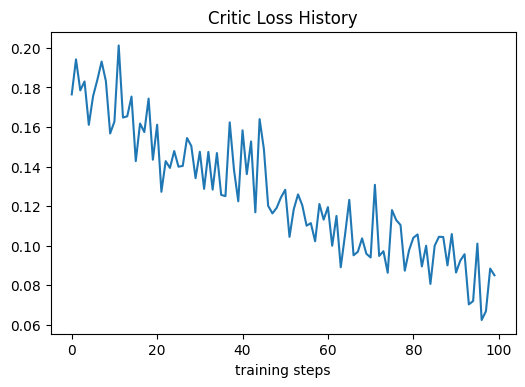

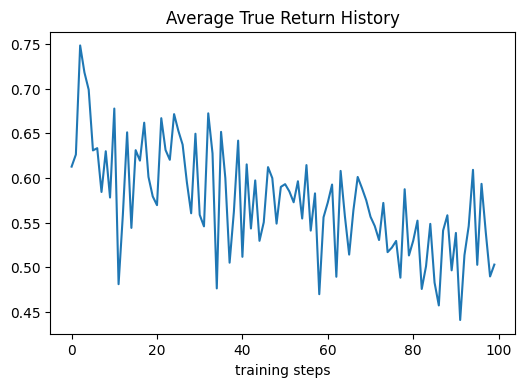

In [25]:
x = range(len(critic_network_loss_history))
plt.figure(dpi=100)
plt.plot(x, critic_network_loss_history)
plt.title('Critic Loss History')
plt.xlabel('training steps')


x = range(len(average_true_return_history))
plt.figure(dpi=100)
plt.plot(x, average_true_return_history)
plt.title('Average True Return History')
plt.xlabel('training steps')

## Generate sequences 

In [26]:
N_gen = 100
generated_seqs = generate_sequences(N_gen, generator, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)

In [27]:
generated_seqs

[[[1.0, 0.0],
  [3.0, 4.338781259817757],
  [2.0, 30.857736923520534],
  [2.0, 10.701790059159368],
  [3.0, 12.92087783993695],
  [5.0, 19.622534212933843],
  [4.0, 13.72447179349561],
  [4.0, 16.377229761508207],
  [3.0, 20.85677755128969],
  [2.0, 21.133632338163597],
  [5.0, 23.91839839334917],
  [4.0, 23.942117445532723],
  [5.0, 25.36536182671317],
  [3.0, 21.298901190388307],
  [3.0, 10.45991368271046],
  [3.0, 30.977979685840943],
  [2.0, 15.849830087146062],
  [2.0, 12.195003840137595],
  [3.0, 24.996400667192624],
  [4.0, 16.684439100055],
  [4.0, 20.767599066080834]],
 [[1.0, 0.0],
  [3.0, 8.916652714418028],
  [3.0, 12.015478619186204],
  [4.0, 27.868298311947605],
  [4.0, 31.720177065261765],
  [4.0, 21.90961399890554],
  [4.0, 17.919807593104377],
  [4.0, 30.049850196148654],
  [4.0, 11.072271755523904],
  [4.0, 14.98146716588149],
  [4.0, 21.311650595688228],
  [3.0, 35.83995807176369],
  [2.0, 21.07512054746315],
  [4.0, 15.428974703692768],
  [5.0, 19.50151603741637],
 

## predict use GAN trained D

In [28]:
generated_seqs = np.array(generated_seqs)
pred_1 = discriminator((generated_seqs[:,:,[0]], generated_seqs[:,:,[1]]))

In [29]:
pred_1.numpy().mean(axis=0)

array([0.53409886])

## predict use pre-trained D

In [30]:
reload_pretrained_D = build_D_2(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_D.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

D_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_disc_weights/model.tf'
reload_pretrained_D.load_weights(D_save_path)

In [31]:
generated_seqs = np.array(generated_seqs)
pred_2 = reload_pretrained_D((generated_seqs[:,:,[0]], generated_seqs[:,:,[1]]))

In [32]:
pred_2.numpy().mean(axis=0)

array([0.87188042])

## Save G and D models and loss

In [33]:
loss_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq_2/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'critic_network_loss_history.pickle'), 'wb') as f:
    pickle.dump(critic_network_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_ce_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_ce_loss_history, f)

In [34]:
D_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq_2/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

In [35]:
G_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq_2/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [36]:
critic_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq_2/critic_weights'
if not os.path.exists(critic_save_dir):
    os.makedirs(critic_save_dir)
    
critic_save_path = os.path.join(critic_save_dir, 'critic_model.tf')
critic.save_weights(critic_save_path)

## Debug Session 

In [ ]:
batch_size = BATCH_SIZE
init_token = 1
end_token = 0
max_time = 1024
G = generator

In [ ]:
# Begin from dummy init state (init_token=1, init_timestamp=0.0)
curr_state_et = tf.ones([batch_size, 1, 1], dtype=tf.float64)
curr_state_ts = tf.zeros([batch_size, 1, 1], dtype=tf.float64)

all_state_et = curr_state_et
all_state_ts = curr_state_ts

episode_token_probs = tf.constant(1., dtype=tf.float64, shape=(batch_size, 1))
gaussian_log = tf.constant(0., dtype=tf.float64, shape=(batch_size, 1))

G.reset_states()

for step in range(1, T):  # sequence length
    token_prob, time_out = G([curr_state_et, curr_state_ts])

    sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
    sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

    # get the chosen token probability per batch for each step
    batch_sample_et = tf.reshape(sampled_et, (batch_size, 1))
    batch_ind = tf.reshape(tf.range(0, batch_size), (batch_size, 1))
    batch_sample_et_2d = tf.concat([batch_ind, batch_sample_et], axis=1)

    sampled_token_prob = tf.reshape(tf.gather_nd(token_prob, batch_sample_et_2d), (batch_size, 1))
    episode_token_probs = tf.concat([episode_token_probs, sampled_token_prob], axis=1)
    
    # cast sampled_et into float
    sampled_et = tf.cast(sampled_et, dtype=tf.float64)
    
    # stop genererating once hit end_token
    cond_end_token = tf.equal(curr_state_et, end_token)
    curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
    all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

    # generate one timstamp using time_out
    sampled_ts_raw = time_out.sample()
    sampled_ts = tf.clip_by_value(tf.reshape(sampled_ts_raw, (batch_size, 1, 1))
                                  , clip_value_min=1, clip_value_max=max_time)

    # get the gaussian log likelihood for the sampled timestamps
    sampled_gaussian_log = time_out.log_prob(sampled_ts_raw)
    gaussian_log = tf.concat([gaussian_log, sampled_gaussian_log], axis=1)

    # stop generating once hit end_token
    curr_state_ts = tf.where(cond_end_token, curr_state_ts, sampled_ts)
    all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)

In [ ]:
all_state_et

In [ ]:
token_prob

In [ ]:
curr_state_et

In [ ]:
sampled_et

In [ ]:
tf.gather_nd(token_prob, tf.reshape(sampled_et, (batch_size, 1)))

In [ ]:
sample_et_2 = tf.reshape(sampled_et, (batch_size, 1))
batch_ind = tf.reshape(tf.range(0, batch_size), (batch_size, 1))
sample_ed_3 = tf.concat([batch_ind, sample_et_2], axis=1)

In [ ]:
tf.gather_nd(token_prob, sample_ed_3)